In [47]:
import sys
sys.path.append('../modules')

from operators import *
from preprocessing import *
from eof import *
from gridding import *
from mapper import *
from scipy.stats import linregress

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature
import seaborn as sns
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Snowload
---
Load data and interpolate the design value field

In [48]:
PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/design_values/snw/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load.nc'
mask_path = '/home/nannau/Desktop/climpyrical/data/mask.nc'
dv = 'snw'

interp_dict = get_interpolation(mask_path, PATH, dv)
master_idx = interp_dict['idx']
iens = (interp_dict['iens'][:, master_idx])

iens.shape

(35, 799963)

Plot distribution.

Text(0.5, 1.0, 'KDE Distribution of snw Values')

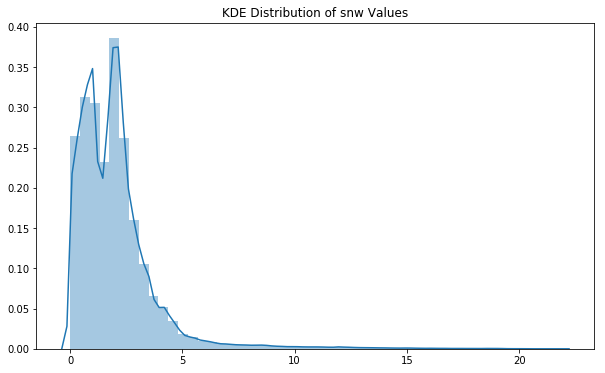

In [5]:
plt.figure(figsize=(10, 6))
sns.distplot(iens[0, ...])
plt.title('KDE Distribution of {} Values'.format(dv))

Perform singular value decomposition

In [6]:
u, s, vT = np.linalg.svd(iens, full_matrices=False)
del u

Calculate explained variance and plot

Text(0, 0.5, 'Explained Variance Ratio')

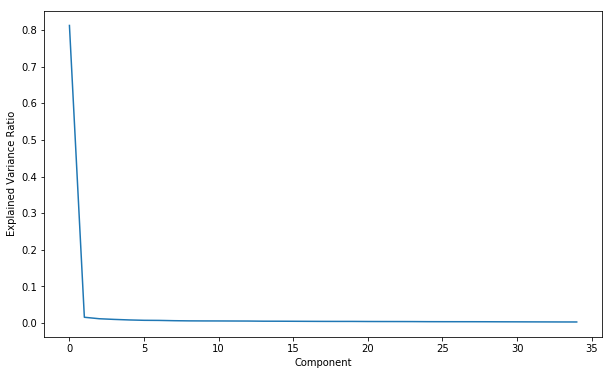

In [7]:
explained_variance_ratio = [s[i]/np.sum(s) for i in range(s.shape[0])]
cumulative_variance = np.cumsum(explained_variance_ratio)
component = range(s.shape[0])

plt.figure(figsize=(10, 6))
plt.plot(component, explained_variance_ratio)
plt.xlabel('Component')
plt.ylabel('Explained Variance Ratio')

Load the quantile station data

In [8]:
df = pd.read_csv('/home/nannau/Downloads/Interim_snow_rain_load_LRstations_delivered.csv', index_col=None)
df.head()

,id,SD_station_name,lat,lon,prov,elevation,SL50 (kPa),RL50 (kPa)
0,15,CHEMAINUS,48.9350,-123.742,BC,75.0,1.954635,0.086293
1,78,SAANICHTON CDA,48.6217,-123.419,BC,61.0,0.729036,0.772268
2,91,SHAWNIGAN LAKE,48.6469,-123.626,BC,159.0,2.352290,0.586493
3,109,VICTORIA GONZALES HTS,48.4131,-123.325,BC,69.5,0.752725,0.764285
4,149,ALERT BAY,50.5833,-126.933,BC,59.4,1.420390,0.564503


In [9]:
dv = 'SL50 (kPa)'

In [10]:
ndf = match_coords(df, interp_dict, dv)
print("There are ", ndf.shape, "real station observations to fit.")

There are  (477, 7) real station observations to fit.


#### Create the pseudo observations and regress

In [12]:
obs_idx = generate_pseudo_obs(iens, 0.0003)
print("Taking", obs_idx.shape[0], "pseudo observations")

Taking 239 pseudo observations


In [13]:
obs = iens[0, obs_idx]
eofs = vT[:, obs_idx]

print("Check that the pseudo observations and the EOFs contain the same number of grids:",
      '\nEOF shape: ', eofs.shape, '\n'
      'Matched Obs shape: ', obs.shape)

Check that the pseudo observations and the EOFs contain the same number of grids: 
EOF shape:  (35, 239) 
Matched Obs shape:  (239,)


Fit the EOFs tot he pseudo observations and predict their values

In [14]:
model = fit_eof(eofs.T, obs.flatten())
predictions = predict_dv(model, eofs.T)

Regressed model score: 1.0 1.0


slope 1.0000000000000007 r2_val 1.0


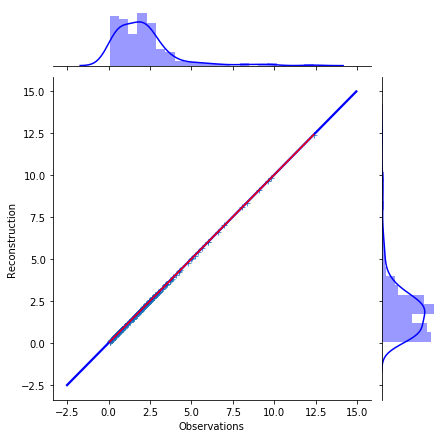

In [15]:
sns.jointplot(obs.T, predictions.T, kind='reg', color='blue',  marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(obs.T, predictions.T, marker='+')
sns.lineplot(obs.T, obs.T, color='r', dashes=True)
plt.xlabel('Observations')
plt.ylabel('Reconstruction')

slope, intercept, r_value, p_value, std_err = linregress(obs.T, predictions.T)
print("slope", slope, "r2_val", r_value)

#### Use the real observations and regress

In [16]:
robs_idx = ndf['matched_idx']
robs = (ndf[dv].values) # fix units
reofs = vT[:, robs_idx].T
reofs.shape, robs.shape, obs.shape

((477, 35), (477,), (239,))

In [22]:
yslopes = []
ys = []
x = eofs.T
for i in range(0, 100):
    yslopes = []
    for sd in np.linspace(0, np.std(robs)):
        y = obs.flatten() + np.random.normal(0., sd, obs.flatten().shape[0])
        model = fit_eof(x, y)
        predictions = predict_dv(model, x)
        slope, intercept, r_value, p_value, std_err = linregress(y, predictions)
        yslopes.append(slope)
    ys.append(yslopes)

In [25]:
ys = np.array(ys)
ys.max(axis=0), ys.min(axis=0), ys.mean(axis=0)
sns.lineplot(ys.mean(axis=0))

(array([1.        , 0.99959455, 0.99836143, 0.99636904, 0.99338642,
        0.98888468, 0.98488593, 0.98085177, 0.97486186, 0.97125672,
        0.959246  , 0.95170183, 0.94972366, 0.93907015, 0.92829878,
        0.92451676, 0.90273707, 0.90034087, 0.88979964, 0.88531804,
        0.86717985, 0.85030289, 0.84729633, 0.83503489, 0.83578019,
        0.82260435, 0.79989276, 0.78992239, 0.76856781, 0.75121882,
        0.75913871, 0.76401896, 0.74235198, 0.75347941, 0.70142913,
        0.72515349, 0.7132023 , 0.69637719, 0.67108476, 0.67399854,
        0.6556192 , 0.65335644, 0.64633463, 0.64168266, 0.60219929,
        0.63578536, 0.61673803, 0.58125566, 0.58935603, 0.56645625]),
 array([1.        , 0.99934742, 0.99742043, 0.99427371, 0.98971519,
        0.98345889, 0.97632739, 0.9691365 , 0.96040917, 0.94365618,
        0.93911628, 0.92389462, 0.90931089, 0.90191195, 0.88037599,
        0.86588782, 0.8482808 , 0.8253967 , 0.81729175, 0.8102782 ,
        0.78610193, 0.77289165, 0.75039021, 0.

Text(0, 0.5, 'Slope/R$^2$ Score')

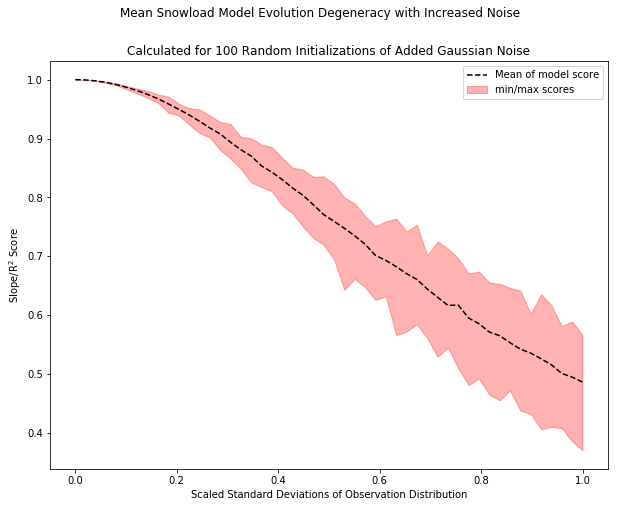

In [45]:
fig, ax = plt.subplots(figsize=(10, 7.5))
plt.plot(np.linspace(0, np.std(robs))/np.std(robs), ys.mean(axis=0), color='black', linestyle='--', label='Mean of model score')
ax.fill_between(np.linspace(0, np.std(robs))/np.std(robs), ys.min(axis=0), ys.max(axis=0), alpha = 0.3, color='red', label='min/max scores')
plt.legend()
plt.suptitle('Mean Snowload Model Evolution Degeneracy with Increased Noise')
plt.title('Calculated for 100 Random Initializations of Added Gaussian Noise')
plt.xlabel('Scaled Standard Deviations of Observation Distribution')
plt.ylabel('Slope/R$^2$ Score')

Compare the distributions of the station observations and of the models

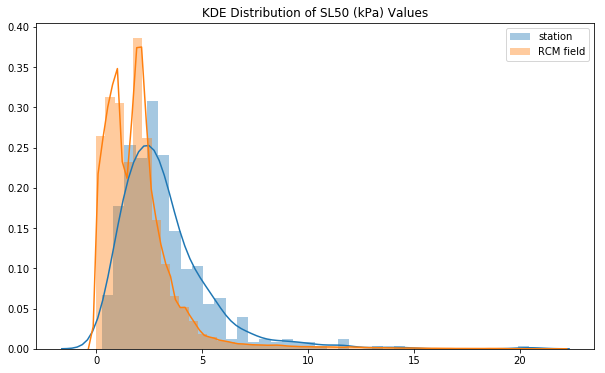

In [18]:
plt.figure(figsize=(10, 6))
plt.title('KDE Distribution of {} Values'.format(dv))
sns.distplot(robs, label='station')
sns.distplot(iens[0, ...], label='RCM field')
plt.legend()

Fit the model and predict it

In [19]:
rmodel = fit_eof(reofs, robs.flatten())
linrpredictions = predict_dv(rmodel, reofs).flatten()
linrpredictions.shape

Regressed model score: 0.310929775099988 0.310929775099988


(477,)

In [46]:
sns.jointplot(robs, linrpredictions, ax=ax,  kind='reg', color='blue', marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(robs, linrpredictions,
                marker='+',
                hue=ndf['lon'],
                )

sns.lineplot(robs.T, 
            robs.T,
            color='r',
            dashes=True)


ax.set_xlabel('Observations')
ax.set_ylabel('Reconstruction')

slope, intercept, r_value, p_value, std_err = linregress(robs, linrpredictions)
print("slope", slope, "r2_val", r_value)

print("Std deviation ratio of vectors [models/]:", np.mean(np.std(iens, axis=1))/np.std(robs))

NameError: name 'linrpredictions' is not defined

slope 0.3366430702110283 r2_val 0.5802095054469794
Std deviation ratio of vectors [models/]: 0.9787770748404654


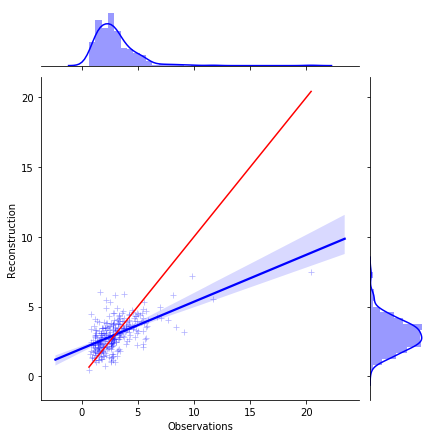

In [74]:
sns.jointplot(robs, linrpredictions, kind='reg', color='blue', marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(robs, linrpredictions, 
                color="blue",
                marker='+',
                alpha=0.3)

sns.lineplot(robs.T, 
          robs.T,
          color='r',
            dashes=True)

plt.xlabel('Observations')
plt.ylabel('Reconstruction')

slope, intercept, r_value, p_value, std_err = linregress(robs, linrpredictions)
print("slope", slope, "r2_val", r_value)

print("Std deviation ratio of vectors [models/]:", np.mean(np.std(iens, axis=1))/np.std(robs))

In [31]:
dv_recon = interp_dict['iens'][0, ...].copy()
dv_recon[master_idx] = rmodel.predict(vT.T)

In [32]:
dv_recon_sq = dv_recon.reshape(interp_dict['irlat'].shape[0], interp_dict['irlon'].shape[0])

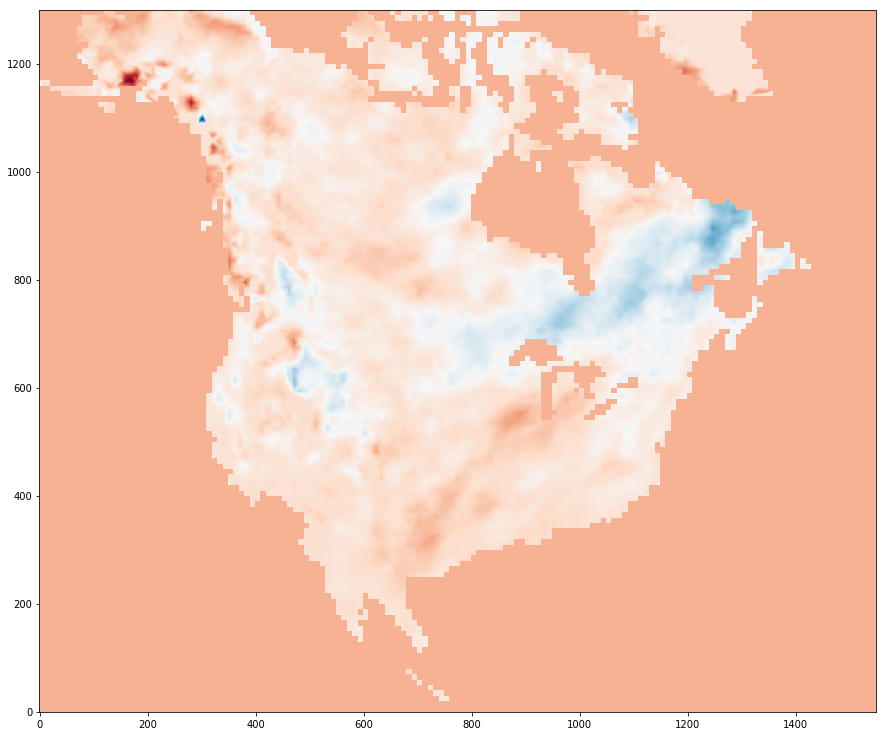

In [33]:
plt.figure(figsize=(15, 15))
plt.imshow(dv_recon_sq, cmap='RdBu', origin='lower')
plt.savefig('reconstruction_snow.pdf')